In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model
import os
from google.colab import drive
import zipfile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import csv
import time
import matplotlib.gridspec as gridspec

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
  from thop import profile, clever_format
except:
    print("[INFO] Couldn't find thop... installing it.")
    !pip install thop
    from thop import profile, clever_format

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find thop... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.3 MB/s eta 0:00:00
     ━━

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(f"[INFO] Using {torch.cuda.get_device_name(0)}")
else:
    print("[INFO] Using CPU")

[INFO] Using Tesla V100-SXM2-16GB


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation'
file_dir = '/content/evaluation'

#Upload train data folder to google colab files directory
if not os.path.exists(file_dir):
  os.makedirs(file_dir)
  zip_train= zipfile.ZipFile(os.path.join(folder_path, 'train_images.zip'), 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [ ]:
class_dict = {0 : "safe driving",
              1 : "drinking",
              2 : "talking on the phone - left",
              3 : "talking on the phone - right",
              4 : "texting - left",
              5 : "texting - right",
              6 : "Doing hair",
              7 : "Adjusting specs",
              8 : "Reaching behind",
              9 : "Sleeping"}

In [ ]:
front_view_dir = "/content/evaluation/train_dual/front_RGB"
side_view_dir = "/content/evaluation/train_dual/side_RGB"
classes = [c for c in os.listdir(front_view_dir) if not c.startswith(".")]
classes.sort()
num_classes = len(classes)
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Total number of  data : 3000
{'0': 300, '1': 300, '2': 300, '3': 300, '4': 300, '5': 300, '6': 300, '7': 300, '8': 300, '9': 300}


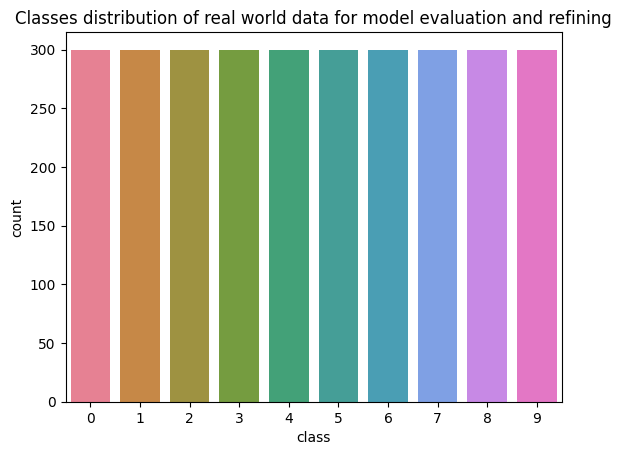

In [ ]:
d = {"img" : [], "class" : []}
data_count = {}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(front_view_dir,c)) if not img.startswith(".")]
    data_count[c] = len(imgs)
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="Classes distribution of real world data for model evaluation and refining")
print("Total number of  data :",len(df))
print(data_count)

In [ ]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("PairedDriverDataset", "/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/TwoStreamPairedDataset.py")
paired_driver_dataset_module  = importlib.util.module_from_spec(spec)
spec.loader.exec_module(paired_driver_dataset_module)
PairedDriverDataset = paired_driver_dataset_module.PairedDriverDataset

In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

In [ ]:
data = PairedDriverDataset(
    front_dir = front_view_dir,
    side_dir = side_view_dir,
    file_type = 'eval',
    transform = transform
)

print(len(data))

3000


In [ ]:
num_pairs = 20
fig, axs = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))

for i in range(num_pairs):
  idx = np.random.randint(0, len(data))  # Random index
  front_image, side_image, class_idx = data[idx]  # Fetch images and class index

  # Convert tensors back to PIL images for display purposes
  # Skip these lines if your transform does not convert images to tensors
  front_image = transforms.ToPILImage()(front_image)
  side_image = transforms.ToPILImage()(side_image)

  class_name = class_dict[class_idx]

  # Plot front image
  axs[i, 0].imshow(front_image)
  axs[i, 0].set_title(f"Front View {i}: {class_name}")
  axs[i, 0].axis('off')

  # Plot side image
  axs[i, 1].imshow(side_image)
  axs[i, 1].set_title(f"Side View {i}: {class_name}")
  axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
batch_size = 16
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
front_folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/mobilenetv3l_front(unfreeze)/'
side_folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/mobilenetv3_side/'

model_path1 = os.path.join(front_folder_path, 'my_checkpoint.pth.tar')
model_path2 = os.path.join(side_folder_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    front_checkpoint = torch.load(model_path1)
    side_checkpoint = torch.load(model_path2)


In [ ]:
spec = importlib.util.spec_from_file_location("TwoStreamMobileNetV3L", "/content/drive/MyDrive/DAR_Deep Learning Model/TwoStreamMobileNetV3L.py")
TwoStreamMobileNetV3L = importlib.util.module_from_spec(spec)
sys.modules["TwoStreamMobileNetV3L"] = TwoStreamMobileNetV3L
spec.loader.exec_module(TwoStreamMobileNetV3L)

In [ ]:
model = None

if model == None:
  model = TwoStreamMobileNetV3L.TwoStreamMobileNetV3L(front_checkpoint, side_checkpoint)

load_path = "/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/2streammobilenetv3l/"

checkpoint_path = os.path.join(load_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

for param in model.classifier.parameters():
    param.requires_grad = False

# Load the model state
model.load_state_dict(checkpoint['state_dict'])



# Move the model to the device
model.to(device)

TwoStreamMobileNetV3L(
  (model1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNorm

In [ ]:
summary(model=model,
        input_size=[(16, 3, 224, 224), (16, 3, 224, 224)],  # Corrected typo from 244 to 224
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TwoStreamMobileNetV3L (TwoStreamMobileNetV3L)                     [16, 3, 224, 224]    [16, 10]             --                   False
├─MobileNetV3 (model1)                                            --                   --                   1,242,890            False
│    └─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (2)                                  [16, 16, 112, 112]   [16, 24, 56, 56]     (3,440)              False
│    │    └─InvertedResidual (3)                   

In [ ]:
front_input, side_input, label = next(iter(data_loader))
front_input = front_input.to(device)
side_input = side_input.to(device)
flops, params = profile(model, inputs=(front_input, side_input ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


In [ ]:
total_images = len(data)
total_images

3000

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total inference time for the entire dataset is 17.2068 seconds
Frame per second (FPS): 174
Floating Point Operations Per Second (FLOPS): 747.0 M
Precision: 70.54%
Recall: 45.90%
Test accuracy: 45.90%
F1 Score: 42.18%


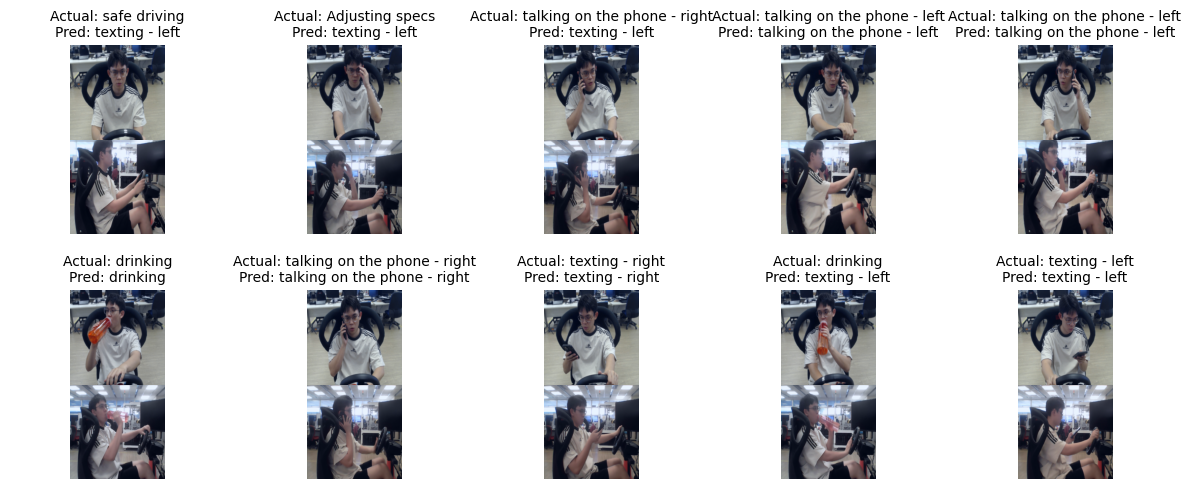

In [ ]:
# Parameters for visualization
num_pairs_to_display = 10
images_to_display = []
images_per_row = 5  # 5 pairs per row, but each pair has 2 images


# Prepare the figure for visualization
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(int(np.ceil(num_pairs_to_display*2 / images_per_row)), images_per_row, figure=fig, hspace=0.3, wspace=0.1)


# Start the timer
start_time = time.time()

#Prediction phase
all_preds = []
all_true_labels = []
# Lists to collect data for visualization (indices or references)
data_for_visualization = []

model.eval()
with torch.no_grad():
    for i, (X1_test, X2_test, y_test) in enumerate(data_loader):
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        y_test = y_test.to(device)

        test_pred = model(X1_test, X2_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        actual = y_test.cpu().numpy()
        all_true_labels.extend(actual)

        # Collect data for visualization
        for j in range(X1_test.size(0)):
          data_for_visualization.append((X1_test[j], X2_test[j], actual[j], preds[j]))

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)

# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frame per second (FPS): {int(total_images/total_time)}")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")

for i, (X1, X2, actual, pred) in enumerate(data_for_visualization):
    if i >= num_pairs_to_display:
        break

    image1 = X1.cpu().numpy().transpose((1, 2, 0))
    image2 = X2.cpu().numpy().transpose((1, 2, 0))

    # Normalize images for visualization
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())

    row = (i // images_per_row)
    col = i % images_per_row

    # Create a subplot for the pair
    ax_pair = plt.Subplot(fig, gs[row, col])
    fig.add_subplot(ax_pair)
    ax_pair.axis('off')

    # Create an inset axis for each image within the pair
    ax1 = ax_pair.inset_axes([0, 0.5, 1, 0.5])  # Top image
    ax2 = ax_pair.inset_axes([0, 0, 1, 0.5])  # Bottom image

    # Adjust the vertical spacing between the images in a pair
    ax1.set_title(f"Actual: {class_dict.get(actual, 'Unknown')}\nPred: {class_dict.get(pred, 'Unknown')}", fontsize=10)
    ax1.imshow(image1)
    ax1.axis('off')

    ax2.imshow(image2)
    ax2.axis('off')

plt.show()

In [ ]:
# Initialize a counter for misclassified images
num_misclassified = 0

# Calculate the number of misclassified images
for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

print(f"Number of misclassified images: {num_misclassified}")

Number of misclassified images: 1623


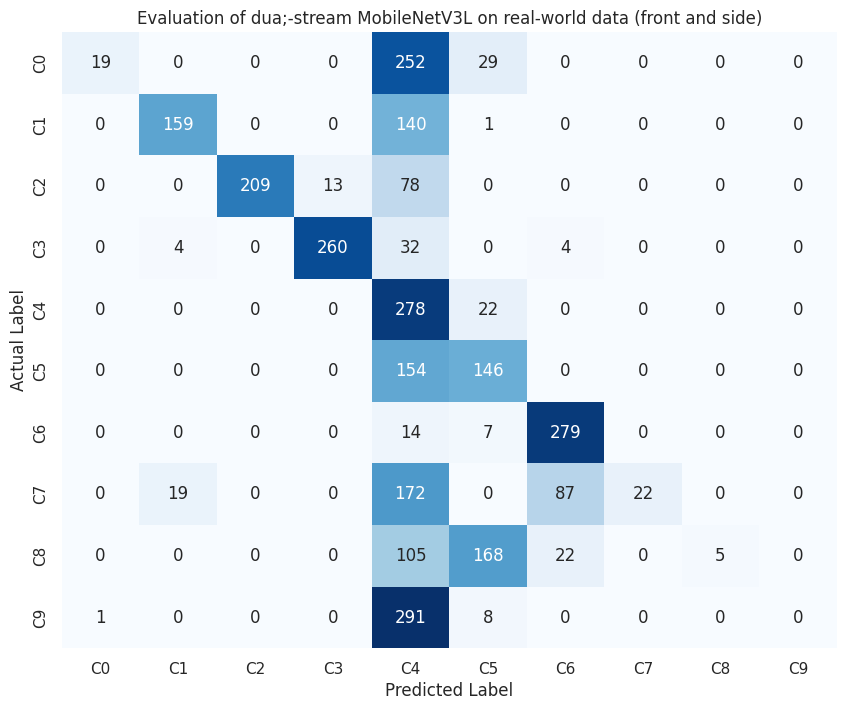

In [ ]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Evaluation of dua;-stream MobileNetV3L on real-world data (front and side)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Base directories for saving images
front_correct_dir = os.path.join(folder_path, "dual_classified_images/correct/front_RGB")
side_correct_dir = os.path.join(folder_path, "dual_classified_images/correct/side_RGB")
front_misclassified_dir = os.path.join(folder_path, "dual_classified_images/misclassified/front_RGB")
side_misclassified_dir = os.path.join(folder_path, "dual_classified_images/misclassified/side_RGB")
os.makedirs(front_correct_dir, exist_ok=True)
os.makedirs(side_correct_dir, exist_ok=True)
os.makedirs(front_misclassified_dir, exist_ok=True)
os.makedirs(side_misclassified_dir, exist_ok=True)

In [ ]:
for i, (front_image_np, side_image_np, true_label, pred) in enumerate(data_for_visualization):
    front_image = front_image_np.cpu().numpy().transpose((1, 2, 0))
    front_image = (front_image - front_image.min()) / (front_image.max() - front_image.min())  # Normalize
    front_image = (front_image * 255).astype(np.uint8)  # Convert to uint8
    front_image_pil = Image.fromarray(front_image)

    side_image = side_image_np.cpu().numpy().transpose((1, 2, 0))
    side_image = (side_image - side_image.min()) / (side_image.max() - side_image.min())  # Normalize
    side_image = (side_image * 255).astype(np.uint8)  # Convert to uint8
    side_image_pil = Image.fromarray(side_image)

    # Determine if the classification is correct
    is_correct = (pred == true_label)
    front_save_path = front_correct_dir if is_correct else front_misclassified_dir
    side_save_path = side_correct_dir if is_correct else side_misclassified_dir

    # Define the directory based on the true label
    front_label_dir = os.path.join(front_save_path, str(true_label))
    side_label_dir = os.path.join(side_save_path, str(true_label))
    os.makedirs(front_label_dir, exist_ok=True)
    os.makedirs(side_label_dir, exist_ok=True)

    # Save the image
    front_image_file = os.path.join(front_label_dir, f"image_front_actual{true_label}_pred{pred}_{i}.jpg")
    side_image_file = os.path.join(side_label_dir, f"image_side_actual{true_label}_pred{pred}_{i}.jpg")
    front_image_pil.save(front_image_file)
    side_image_pil.save(side_image_file)

In [ ]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

save_path = os.path.join(folder_path, 'dual_unrefined_performance')
os.makedirs(save_path, exist_ok=True)

result_path = os.path.join(save_path, 'model_predictions.csv')
metrics_path = os.path.join(save_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

In [ ]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)

In [ ]:
print(len(os.listdir("/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/dual_classified_images/misclassified/side_RGB/9")))
print(len(os.listdir("/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/dual_classified_images/misclassified/front_RGB/9")))


300
300


In [ ]:
model = None

if model == None:
  model = TwoStreamMobileNetV3L.TwoStreamMobileNetV3L(front_checkpoint, side_checkpoint)

load_path = "/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/2streammobilenetv3l/"

checkpoint_path = os.path.join(load_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

for param in model.classifier.parameters():
    param.requires_grad = True

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

# Move the model to the device
model.to(device)

TwoStreamMobileNetV3L(
  (model1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNorm

In [ ]:
summary(model=model,
        input_size=[(16, 3, 224, 224), (16, 3, 224, 224)],  # Corrected typo from 244 to 224
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TwoStreamMobileNetV3L (TwoStreamMobileNetV3L)                     [16, 3, 224, 224]    [16, 10]             --                   Partial
├─MobileNetV3 (model1)                                            --                   --                   1,242,890            False
│    └─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (2)                                  [16, 16, 112, 112]   [16, 24, 56, 56]     (3,440)              False
│    │    └─InvertedResidual (3)                 

In [ ]:
front_view_dir = "/content/evaluation/train_dual/front_RGB"
side_view_dir = "/content/evaluation/train_dual/side_RGB"

# Instantiate the dataset
data = PairedDriverDataset(
    front_dir = front_view_dir,
    side_dir = side_view_dir,
    file_type = 'eval'
)

torch.manual_seed(42)
print(len(data))
valid_size = int(0.2*len(data))
train_size = len(data)-valid_size

train_data, valid_data = random_split(data, [train_size, valid_size])
print(len(train_data), len(valid_data))

3000
2400 600


In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (244,244)

color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
rotation = transforms.RandomRotation(15)
gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
translation = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))


data_transforms = {
    'train_front': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomApply([color_jitter], p=0.3),
        transforms.RandomApply([rotation], p=0.5),
        transforms.RandomApply([gaussian_blur], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),

    'train_side': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomApply([color_jitter], p=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([translation], p=0.5),
        transforms.RandomApply([rotation], p=0.5),
        transforms.RandomApply([gaussian_blur], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
}

In [ ]:
class TransformDataset(Dataset):
    def __init__(self, dataset, front_transform=None, side_transform=None):
        self.dataset = dataset
        self.front_transform = front_transform
        self.side_transform = side_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        front_image, side_image, label = self.dataset[idx]
        if self.front_transform:
            front_image = self.front_transform(front_image)
        if self.side_transform:
            side_image = self.side_transform(side_image)
        return front_image, side_image, label

In [ ]:
train_data = TransformDataset(train_data, front_transform=data_transforms['train_front'], side_transform=data_transforms['train_side'] )
valid_data = TransformDataset(valid_data, front_transform=data_transforms['valid'], side_transform=data_transforms['valid'])

In [ ]:
num_pairs = 20
fig, axs = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))

for i in range(num_pairs):
  idx = np.random.randint(0, len(train_data))  # Random index
  front_image, side_image, class_idx = train_data[idx]  # Fetch images and class index

  # Convert tensors back to PIL images for display purposes
  # Skip these lines if your transform does not convert images to tensors
  front_image = transforms.ToPILImage()(front_image)
  side_image = transforms.ToPILImage()(side_image)

  class_name = class_dict[class_idx]

  # Plot front image
  axs[i, 0].imshow(front_image)
  axs[i, 0].set_title(f"Front View {i}: {class_name}")
  axs[i, 0].axis('off')

  # Plot side image
  axs[i, 1].imshow(side_image)
  axs[i, 1].set_title(f"Side View {i}: {class_name}")
  axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
train_front_batch, train_side_batch, train_labels_batch = next(iter(train_loader))
train_front_batch.shape, train_side_batch.shape, train_labels_batch.shape

(torch.Size([4, 3, 244, 244]), torch.Size([4, 3, 244, 244]), torch.Size([4]))

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold=0.01, threshold_mode='rel')

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0

In [ ]:
early_stopping = EarlyStopping(patience=10, min_delta=0.005)

In [ ]:
class CSVLogger:
    def __init__(self, filename, fieldnames=['epoch','learning_rate', 'epoch_duration', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc']):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create file and write header
        with open(self.filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writeheader()

    def log(self, epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc):
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow({
                'epoch': epoch,
                'learning_rate': lr,
                'epoch_duration': epoch_duration,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'valid_loss': valid_loss,
                'valid_acc': valid_acc
            })

In [ ]:
log_path = os.path.join(folder_path,'training_log/dual_refined_all')
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [ ]:
logger = CSVLogger(os.path.join(log_path,'training_log.csv'))

In [ ]:
cp_filename = os.path.join(log_path,'my_checkpoint.pth.tar')

def save_checkpoint(state, filename=cp_filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs = 5):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_acc = 0
    min_lr = 1e-7
    # Start the timer
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
      since = time.time()
      print(f"\nEpoch: {epoch}\n-------")
      #------- Training----------
      train_loss, train_acc = 0, 0
      model.train()
      for batch, (X1_train, X2_train, y_train) in enumerate(train_loader):
        model.train()
        # 1. Forward pass
        X1_train = X1_train.to(device)
        X2_train = X2_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()  # Reset gradients at the start of each epoch


        train_pred = model(X1_train, X2_train)
        loss = criterion(train_pred, y_train)
        train_loss +=loss

        # 4. Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y_train, y_pred=train_pred.argmax(dim=1))
        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
          print(f"Looked at {batch * len(X1_train)}/{len(train_loader.dataset)} samples")

      # Divide total train loss by length of train dataloader (average loss per batch per epoch)
      train_loss /= len(train_loader)

      # Divide total accuracy by length of test dataloader (per batch)
      train_acc /= len(train_loader)

      epoch_duration = time.time()-since
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      ### Testing
      # Setup variables for accumulatively adding up loss and accuracy
      valid_loss = 0
      valid_acc = 0
      model.eval()
      with torch.inference_mode():
        for X1_valid, X2_valid,  y_valid in valid_loader:
          # 1. Forward pass
          X1_valid = X1_valid.to(device)
          X2_valid = X2_valid.to(device)
          y_valid = y_valid.to(device)
          valid_pred = model(X1_valid, X2_valid)

          valid_loss += criterion(valid_pred, y_valid)

          # 3. Calculate accuracy (preds need to be same as y_true)
          valid_acc += accuracy_fn(y_true=y_valid, y_pred=valid_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total accuracy by length of test dataloader (per batch)
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

      # Model Checkpointing
      if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

      for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(lr)

      scheduler.step(valid_acc)

      for param_group in optimizer.param_groups:
          param_group['lr'] = max(param_group['lr'], min_lr)

      ## Print out what's happening
      print(f"\nEpoch duration: {epoch_duration:.0f}s, lr: {lr}, Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Valid loss: {valid_loss:.2f}, Valid acc: {valid_acc:.2f}%\n")

      logger.log(epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc)


      early_stopping(valid_acc)
      if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("Finished Training")
    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f}")
    return model, train_losses, train_accuracies,valid_losses, valid_accuracies



In [ ]:
model, train_losses, training_accs, valid_losses, valid_accs = train_model(model, criterion, optimizer, lrscheduler, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 0
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples
=> Saving checkpoint
0.0001

Epoch duration: 24s, lr: 0.0001, Train loss: 0.99929, Train acc: 67.96% | Valid loss: 0.29, Valid acc: 95.33%



  1%|          | 1/100 [00:28<46:20, 28.09s/it]


Epoch: 1
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples
=> Saving checkpoint


  2%|▏         | 2/100 [00:54<44:43, 27.39s/it]

0.0001

Epoch duration: 23s, lr: 0.0001, Train loss: 0.70191, Train acc: 79.96% | Valid loss: 0.17, Valid acc: 97.50%


Epoch: 2
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples
=> Saving checkpoint
0.0001

Epoch duration: 23s, lr: 0.0001, Train loss: 0.53920, Train acc: 85.88% | Valid loss: 0.11, Valid acc: 98.50%



  3%|▎         | 3/100 [01:21<43:47, 27.09s/it]


Epoch: 3
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples
=> Saving checkpoint


  4%|▍         | 4/100 [01:48<43:13, 27.01s/it]

0.0001

Epoch duration: 23s, lr: 0.0001, Train loss: 0.47839, Train acc: 85.96% | Valid loss: 0.08, Valid acc: 98.67%


Epoch: 4
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples
=> Saving checkpoint


  5%|▌         | 5/100 [02:16<43:12, 27.29s/it]

0.0001

Epoch duration: 23s, lr: 0.0001, Train loss: 0.42757, Train acc: 87.46% | Valid loss: 0.06, Valid acc: 99.00%


Epoch: 5
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


  6%|▌         | 6/100 [02:43<42:44, 27.28s/it]

0.0001

Epoch duration: 24s, lr: 0.0001, Train loss: 0.38843, Train acc: 89.96% | Valid loss: 0.05, Valid acc: 99.00%


Epoch: 6
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples
=> Saving checkpoint


  7%|▋         | 7/100 [03:11<42:20, 27.32s/it]

5e-05

Epoch duration: 23s, lr: 5e-05, Train loss: 0.31637, Train acc: 92.38% | Valid loss: 0.04, Valid acc: 99.33%


Epoch: 7
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


  8%|▊         | 8/100 [03:37<41:34, 27.11s/it]

5e-05

Epoch duration: 23s, lr: 5e-05, Train loss: 0.32999, Train acc: 91.00% | Valid loss: 0.04, Valid acc: 99.17%


Epoch: 8
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


  9%|▉         | 9/100 [04:04<41:05, 27.09s/it]

5e-05

Epoch duration: 23s, lr: 5e-05, Train loss: 0.29948, Train acc: 91.96% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 9
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 10%|█         | 10/100 [04:31<40:35, 27.06s/it]

2.5e-05

Epoch duration: 23s, lr: 2.5e-05, Train loss: 0.29219, Train acc: 92.25% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 10
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 11%|█         | 11/100 [04:58<40:10, 27.09s/it]

2.5e-05

Epoch duration: 23s, lr: 2.5e-05, Train loss: 0.27533, Train acc: 92.83% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 11
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 12%|█▏        | 12/100 [05:26<39:58, 27.25s/it]

2.5e-05

Epoch duration: 24s, lr: 2.5e-05, Train loss: 0.30777, Train acc: 91.33% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 12
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 13%|█▎        | 13/100 [05:53<39:23, 27.17s/it]

1.25e-05

Epoch duration: 23s, lr: 1.25e-05, Train loss: 0.27909, Train acc: 92.79% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 13
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 14%|█▍        | 14/100 [06:20<38:53, 27.14s/it]

1.25e-05

Epoch duration: 23s, lr: 1.25e-05, Train loss: 0.26126, Train acc: 93.29% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 14
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 15%|█▌        | 15/100 [06:47<38:28, 27.16s/it]

1.25e-05

Epoch duration: 23s, lr: 1.25e-05, Train loss: 0.27597, Train acc: 92.04% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 15
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 16%|█▌        | 16/100 [07:15<38:06, 27.22s/it]

6.25e-06

Epoch duration: 23s, lr: 6.25e-06, Train loss: 0.26395, Train acc: 93.17% | Valid loss: 0.03, Valid acc: 99.33%


Epoch: 16
-------
Looked at 0/2400 samples
Looked at 400/2400 samples
Looked at 800/2400 samples
Looked at 1200/2400 samples
Looked at 1600/2400 samples
Looked at 2000/2400 samples


 16%|█▌        | 16/100 [07:42<40:27, 28.90s/it]

6.25e-06

Epoch duration: 23s, lr: 6.25e-06, Train loss: 0.26904, Train acc: 93.00% | Valid loss: 0.03, Valid acc: 99.33%

Early stopping triggered
Finished Training
Total training time: 462.47


#Loss and Accuracy Plot for refined training on real world dataset

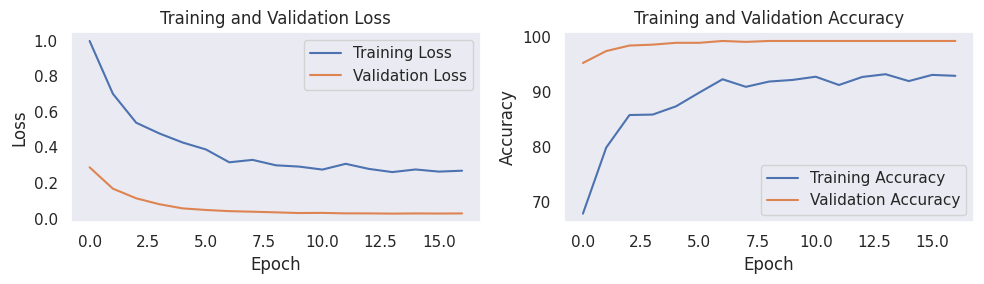

In [ ]:
training_losses_cpu = [loss.detach().cpu().numpy() for loss in train_losses]
valid_losses_cpu = [loss.detach().cpu().numpy() for loss in valid_losses]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(training_losses_cpu, label="Training Loss")
axes[0].plot(valid_losses_cpu, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(False)

axes[1].plot(training_accs, label="Training Accuracy")
axes[1].plot(valid_accs, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


Total number of  data : 2000
{'0': 200, '1': 200, '2': 200, '3': 200, '4': 200, '5': 200, '6': 200, '7': 200, '8': 200, '9': 200}


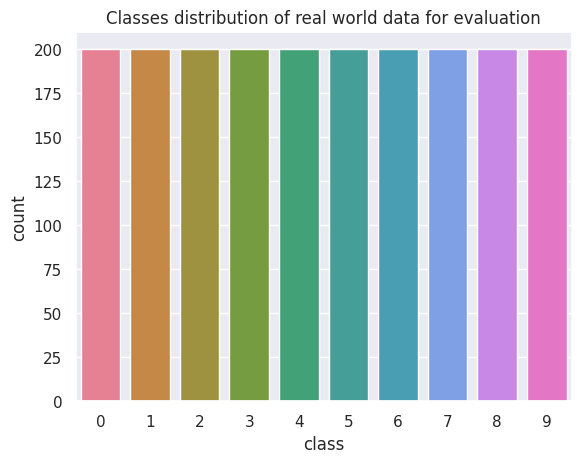

In [ ]:
front_test_path = '/content/evaluation/valid_data/front_RGB'
side_test_path = '/content/evaluation/valid_data/side_RGB'
d = {"img" : [], "class" : []}
data_count = {}
for c in sorted(os.listdir(front_test_path)):
    imgs = [img for img in os.listdir(os.path.join(front_test_path,c)) if not img.startswith(".")]
    data_count[c] = len(imgs)
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="Classes distribution of real world data for evaluation")
print("Total number of  data :",len(df))
print(data_count)

In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

data = PairedDriverDataset(
    front_dir = front_test_path,
    side_dir = side_test_path,
    file_type = 'eval',
    transform = transform
)

In [ ]:
num_pairs = 20
fig, axs = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))

for i in range(num_pairs):
  idx = np.random.randint(0, len(data))  # Random index
  front_image, side_image, class_idx = data[idx]  # Fetch images and class index

  # Convert tensors back to PIL images for display purposes
  # Skip these lines if your transform does not convert images to tensors
  front_image = transforms.ToPILImage()(front_image)
  side_image = transforms.ToPILImage()(side_image)

  class_name = class_dict[class_idx]

  # Plot front image
  axs[i, 0].imshow(front_image)
  axs[i, 0].set_title(f"Front View {i}: {class_name}")
  axs[i, 0].axis('off')

  # Plot side image
  axs[i, 1].imshow(side_image)
  axs[i, 1].set_title(f"Side View {i}: {class_name}")
  axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
batch_size = 16
test_loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_features = model.classifier[0].in_features
output_class = 10

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_features, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_class))

refine_log_path = os.path.join(folder_path,'training_log/side_refined_all')

checkpoint_path = os.path.join(refine_log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

pretrained_features = model.features.to(device)

model.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
summary(model=model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [ ]:
input, label = next(iter(test_loader))
input = input.to(device)
flops, params = profile(model, inputs=(input, ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total inference time for the entire dataset is 6.1517 seconds
Frames Per Second (FPS): 325 seconds
Floating Point Operations Per Second (FLOPS): 373.0 M
Precision: 74.93%
Recall: 78.50%
Test accuracy: 78.50%
F1 Score: 75.30%


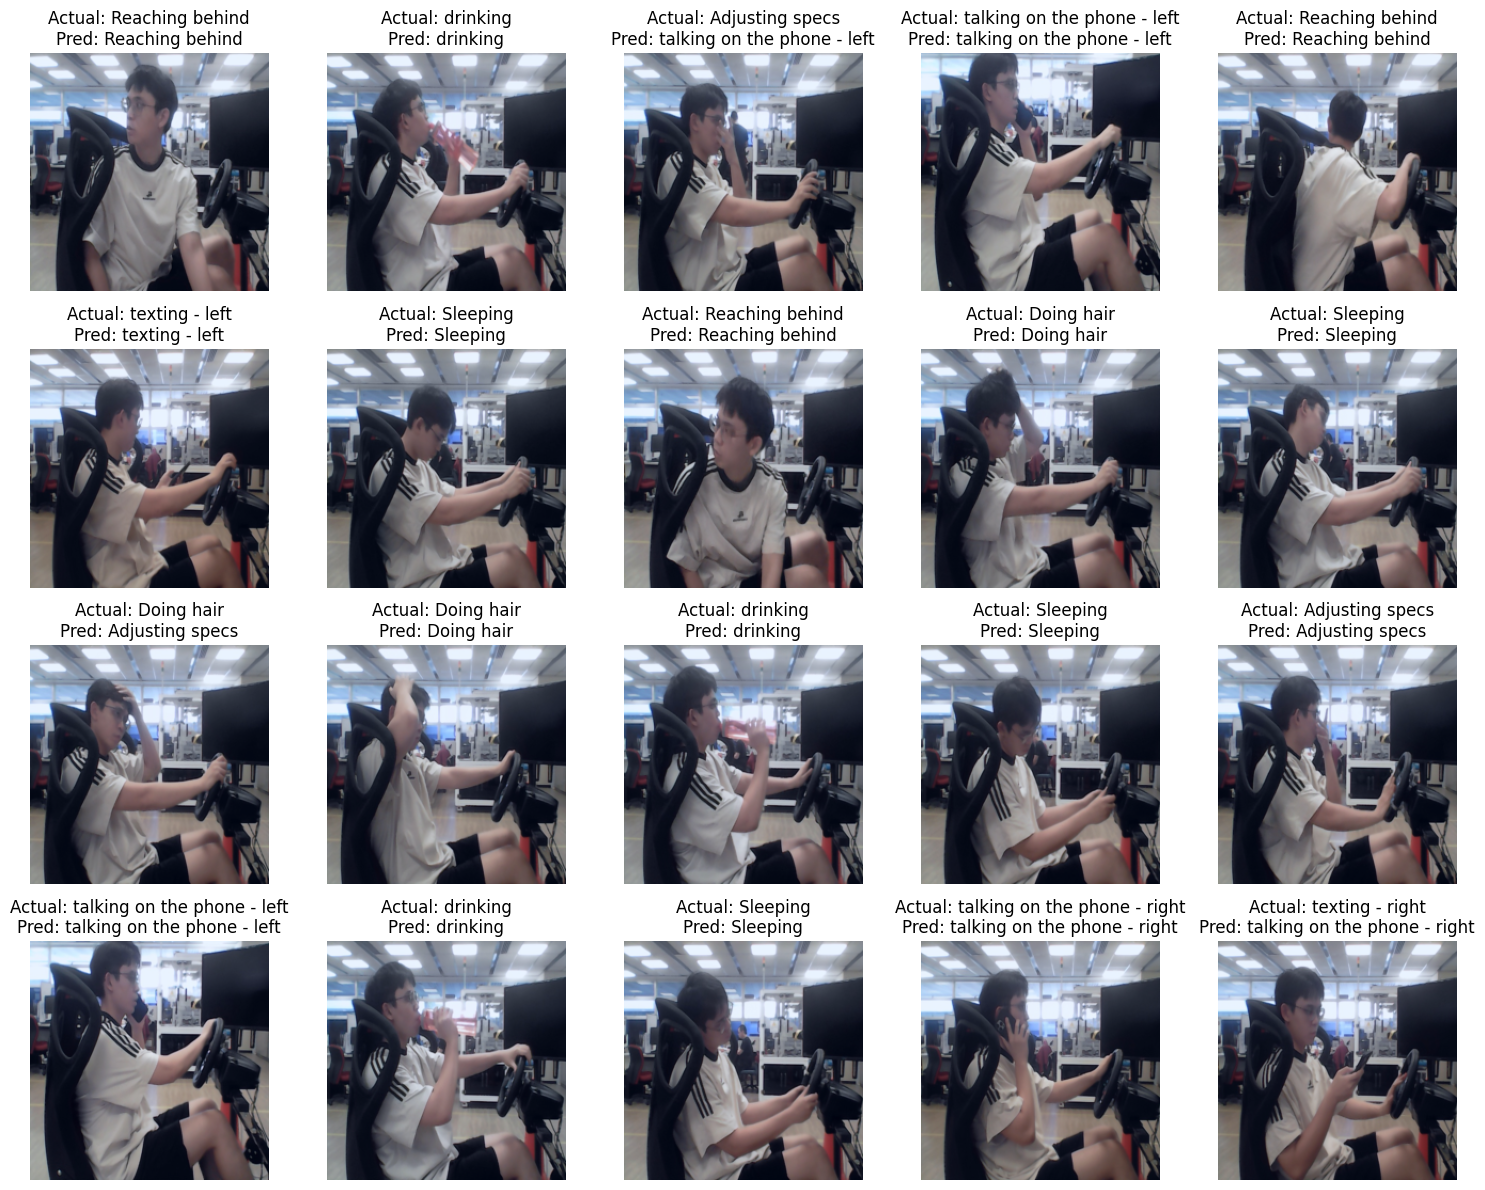

In [ ]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
all_true_labels = []
images_to_display = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true_labels.extend(y_test.cpu().numpy())
        images_to_display.extend(X_test.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frames Per Second (FPS): {int(total_data / total_time)} seconds")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    idx = np.random.randint(0, len(all_preds_np))
    image = images_to_display[idx].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Actual: {class_dict[all_true_labels[idx]]}\nPred: {class_dict[all_preds[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#Evaluation on real word validation data after refined on real world data

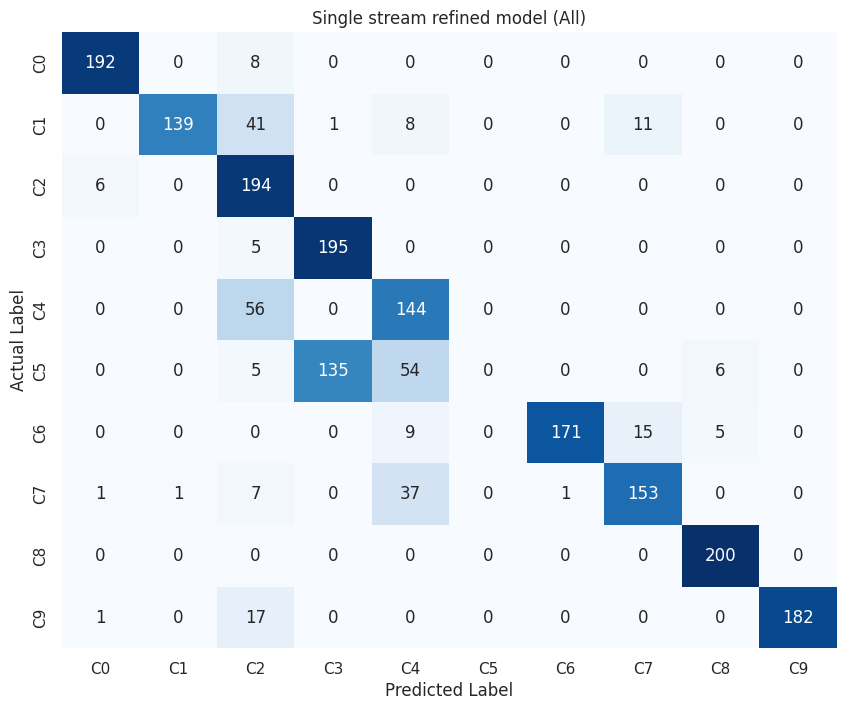

In [ ]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Single stream refined model (All)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Initialize a counter for misclassified images
num_misclassified = 0

# Calculate the number of misclassified images
for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

print(f"Number of misclassified images: {num_misclassified}")


Number of misclassified images: 430


In [ ]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation'

# save_path_misclassified = os.path.join(folder_path, 'unfreeze_single_misclassified')
save_path_all = os.path.join(folder_path, 'side_refined_performance')

os.makedirs(save_path_all, exist_ok=True)

result_path = os.path.join(save_path_all, 'model_predictions.csv')
metrics_path = os.path.join(save_path_all, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

In [ ]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path_all, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)